# Generative Adversarial Network (GAN) - This uses two neural networks namely generator and discriminator. In this project the goal is to train a GAN on the MNIST dataset (handwritten digits) to generate realistic images of digits.

# import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST dataset

In [3]:
(x_train, _), (_, _) = mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Wasserstein loss

In [4]:
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

def gradient_penalty(discriminator, real_images, fake_images, batch_size):
    """Calculates the gradient penalty for WGAN-GP"""
    alpha = tf.random.uniform((batch_size, 1, 1, 1), 0, 1, dtype=tf.float32)
    real_images = tf.cast(real_images, tf.float32)  # Ensure correct data type
    fake_images = tf.cast(fake_images, tf.float32)  # Ensure correct data type
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty

# Generator

In [5]:
def build_generator():
    model = models.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(7 * 7 * 128),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(0.2),
        layers.Conv2D(1, kernel_size=7, activation="tanh", padding="same")
    ])
    return model

# Discriminator

In [6]:
def build_discriminator():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Build generator and discriminator

In [7]:
generator = build_generator()
discriminator = build_discriminator()

# Optimizers

In [8]:
g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)
d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)

# Training parameters

In [9]:
epochs = 10000
batch_size = 64
sample_interval = 1000
lambda_gp = 10

# Training loop, discriminator, and generator

In [10]:
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    # Train Discriminator
    noise = tf.random.normal((batch_size, 100))
    fake_images = generator(noise, training=True)

    with tf.GradientTape() as d_tape:
        real_pred = discriminator(real_images, training=True)
        fake_pred = discriminator(fake_images, training=True)
        gp = gradient_penalty(discriminator, real_images, fake_images, batch_size)
        d_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + lambda_gp * gp

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # Train Generator
    noise = tf.random.normal((batch_size, 100))
    with tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        fake_pred = discriminator(fake_images, training=True)
        g_loss = -tf.reduce_mean(fake_pred)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss


# Save generated images

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def save_generated_images(epoch, n=3):
    noise = np.random.normal(0, 1, (n * n, 100))
    gen_imgs = generator.predict(noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale from [-1,1] to [0,1]

    fig, axs = plt.subplots(n, n, figsize=(6, 6))
    for i in range(n):
        for j in range(n):
            axs[i, j].imshow(gen_imgs[i * n + j, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
    plt.tight_layout()

    # Show in notebook
    plt.show()

    # Save image to file
    fig.savefig(f"generated_epoch_{epoch}.png")
    plt.close(fig)



# Train GAN

In [12]:
def train_gan(x_train):
    for epoch in range(epochs):
        # Get random batch of real images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]

        # Train the GAN
        d_loss, g_loss = train_step(real_images)

        # Print progress
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}/{epochs}, [D loss: {d_loss:.4f}], [G loss: {g_loss:.4f}]")
            save_generated_images(epoch)

In [13]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Seeing [] means:

# TensorFlow currently does NOT detect any GPU on your system. Your training and image generation is running only on your CPU.

# This is why your GAN is super slow. I will use Google Colab for training and image generation.

Epoch 0/10000, [D loss: 8.1931], [G loss: -0.0810]


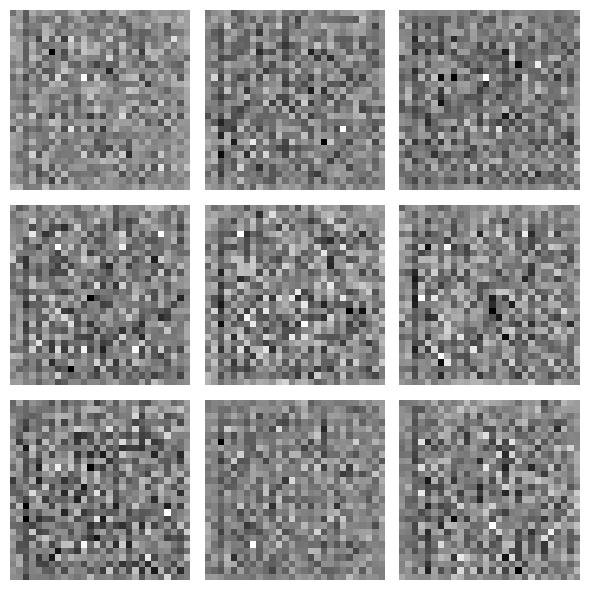

Epoch 1000/10000, [D loss: 0.0000], [G loss: -13.2296]


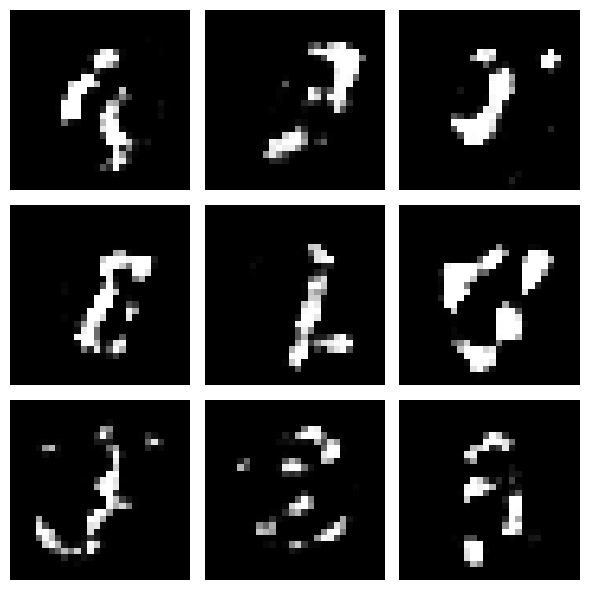

Epoch 2000/10000, [D loss: -0.2972], [G loss: -16.5656]


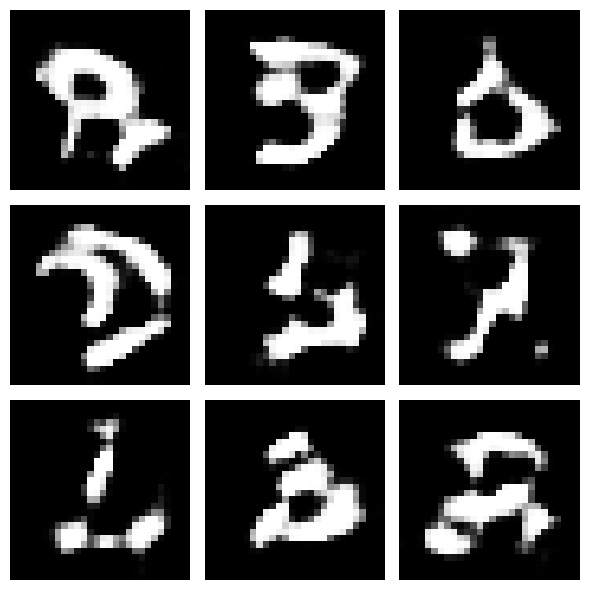

Epoch 3000/10000, [D loss: -0.3465], [G loss: -17.9628]


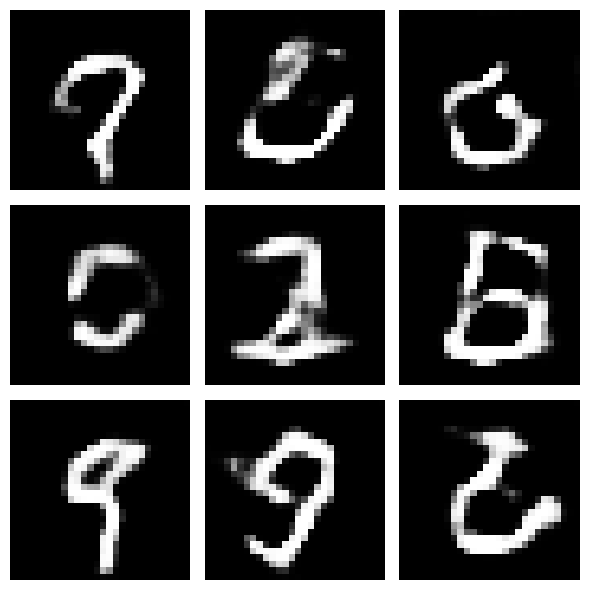

Epoch 4000/10000, [D loss: -0.6044], [G loss: -18.1945]


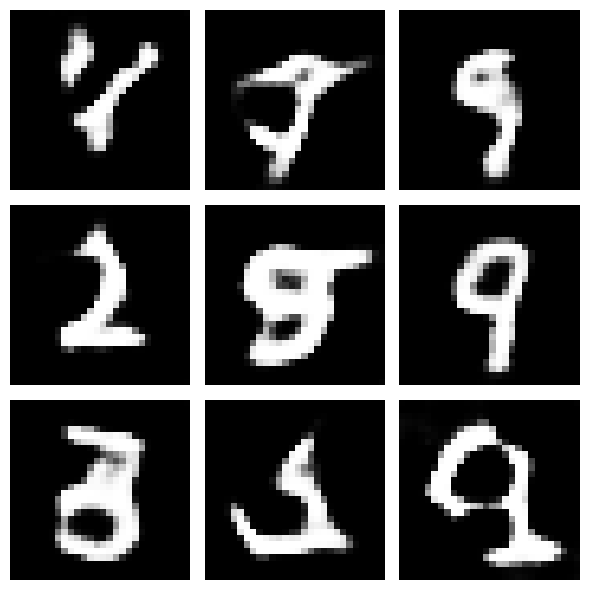

Epoch 5000/10000, [D loss: -0.1598], [G loss: -15.3382]


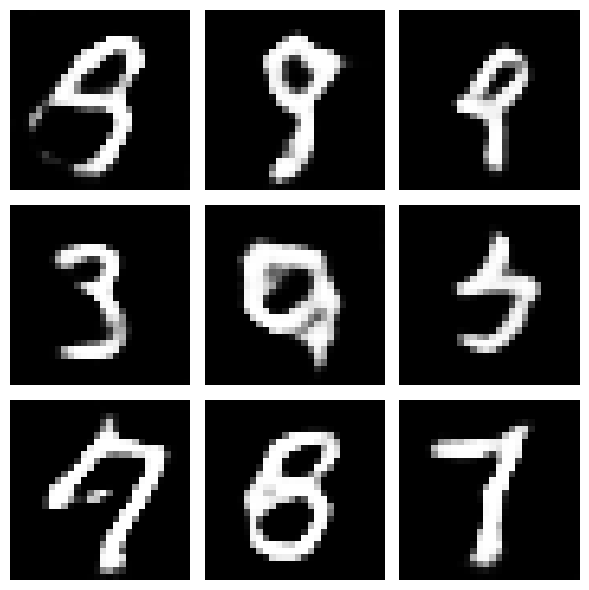

Epoch 6000/10000, [D loss: -0.3706], [G loss: -18.3939]


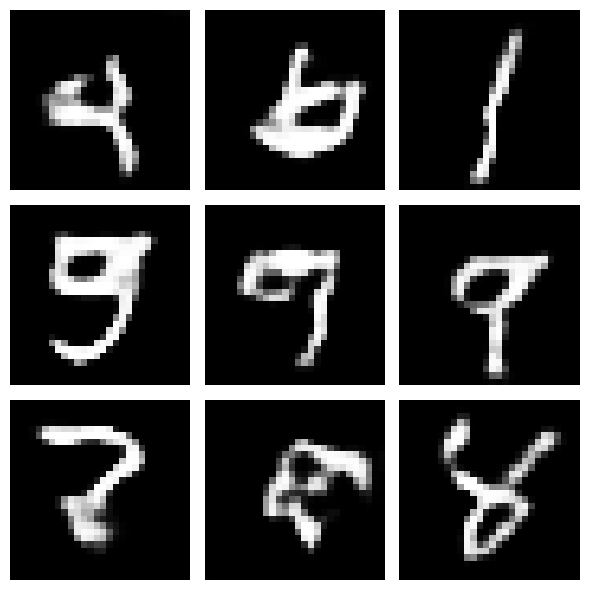

Epoch 7000/10000, [D loss: -0.2105], [G loss: -13.9525]


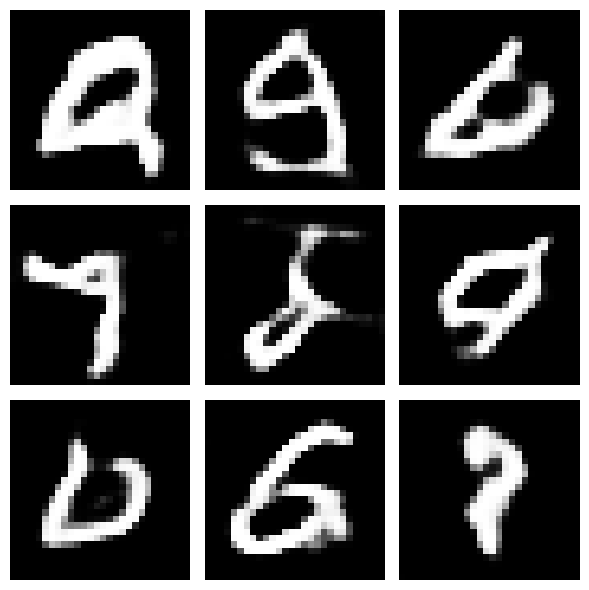

Epoch 8000/10000, [D loss: -0.2482], [G loss: -14.8461]


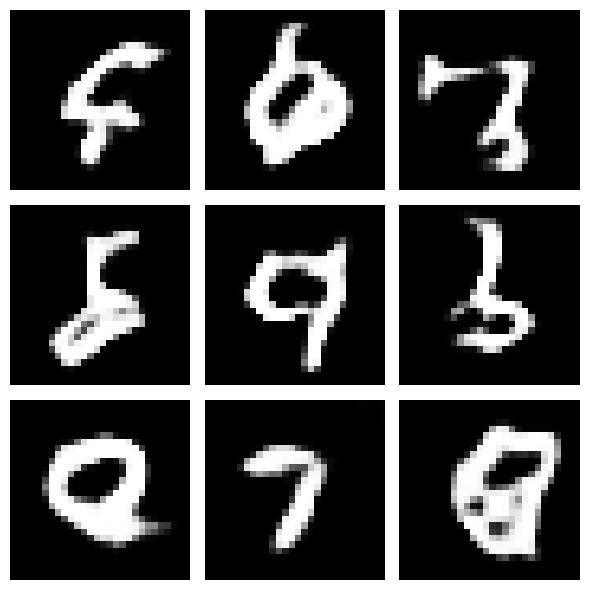

Epoch 9000/10000, [D loss: -0.7506], [G loss: -14.5372]


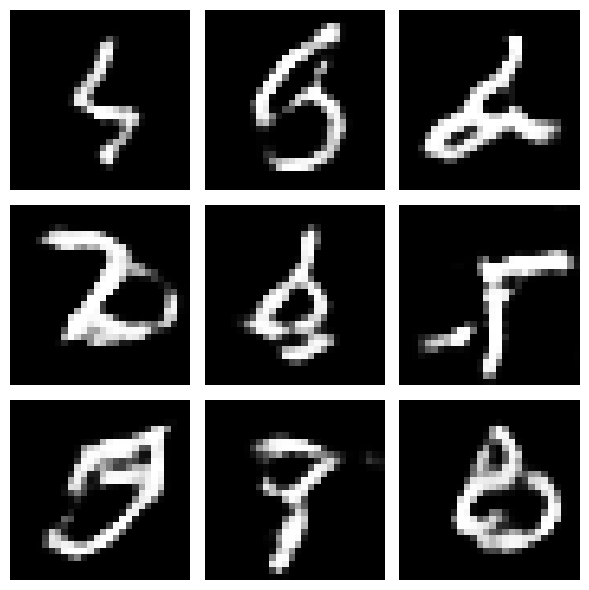

In [14]:
train_gan(x_train)